## Import library

In [1]:
%%capture
!pip install rdkit
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import Chem

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/molecular-machine-learning/train.csv')
test= pd.read_csv('/kaggle/input/molecular-machine-learning/test.csv')
sub = pd.read_csv('/kaggle/input/molecular-machine-learning/sample_submission.csv')

In [4]:
display(train.head(3))
display(test.head(3))

,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
0,Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,...,1.717761,1.970186,1.760071,1.224983,0.664733,0.282353,0.096763,0.034589,0.030793,0.057340
1,Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,...,0.012396,0.046031,0.133124,0.299840,0.525958,0.718549,0.764711,0.634854,0.414866,0.225909
2,Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,...,2.421162,2.703267,2.352276,1.595867,0.845839,0.354620,0.127878,0.060600,0.064782,0.098908


,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
0,Test-01,NaN,COC(=O)c3ccc(c2ccc(c1ccco1)cc2)s3,284.336,4,0,4.4617,0.796737,4.323524,39.44,...,0.709932,0.266678,0.078569,0.020244,0.011813,0.025880,0.061288,0.118430,0.181805,0.220200
1,Test-02,NaN,CCCCCCc2c(CCCCCC)c(c1cccs1)sc2c3ccc(C(=O)OC)cc3,468.728,4,0,9.1758,0.268870,5.019005,26.30,...,1.913133,1.823127,1.356344,0.797689,0.399819,0.236639,0.250003,0.343148,0.426963,0.445557
2,Test-03,NaN,COC(=O)c3ccc(c2ccc(c1cccc(OC)c1)cc2)s3,324.401,4,0,4.8773,0.846029,4.976660,35.53,...,2.302484,1.460937,0.729424,0.299914,0.124335,0.079533,0.080611,0.097277,0.129095,0.178570


## RDKit Feature Generating

In [5]:
def gen_rdkit(df):
    smiles = df.Smiles
    RDKitProp = np.zeros(((smiles.shape[0]),10),dtype = float)
    for d_key, smile in enumerate(smiles):
        #Turns the smiles string into a 3D structure with hydrogens
        mol3d = Chem.AddHs(Chem.MolFromSmiles(smile))
        #Actually creates the molecules
        AllChem.EmbedMolecule(mol3d,randomSeed=random.randint(1,1000000))
        #Optimizes it with the MMFF force-field
        #Note: Force-fields in OpenBabel don't have selenium
        AllChem.MMFFOptimizeMolecule(mol3d)
        RDKitProp[d_key,0] = Descriptors.MolWt(mol3d)
        RDKitProp[d_key,1] = rdMolDescriptors.CalcNumHBA(mol3d)
        RDKitProp[d_key,2] = rdMolDescriptors.CalcNumHBD(mol3d)
        RDKitProp[d_key,3] = Descriptors.MolLogP(mol3d)
        RDKitProp[d_key,4] = rdMolDescriptors.CalcAsphericity(mol3d)
        RDKitProp[d_key,5] = rdMolDescriptors.CalcRadiusOfGyration(mol3d)
        RDKitProp[d_key,6] = Descriptors.TPSA(mol3d)
        RDKitProp[d_key,7] = rdMolDescriptors.CalcNumRings(mol3d)
        RDKitProp[d_key,8] = rdMolDescriptors.CalcNumRotatableBonds(mol3d)
        RDKitProp[d_key,9] = rdMolDescriptors.CalcNumHeteroatoms(mol3d)
    df = pd.concat([df,pd.DataFrame(RDKitProp, columns=[f"RDKit_{i}" for i in range(10)])],axis=1)
    return df
train = gen_rdkit(train)
test = gen_rdkit(test)

[18:37:49] UFFTYPER: Unrecognized atom type: Se2+2 (24)
[18:37:53] UFFTYPER: Unrecognized atom type: Se2+2 (31)
[18:37:57] UFFTYPER: Unrecognized atom type: Se2+2 (23)


## Fit model

In [6]:
train.head(3)

,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,...,RDKit_0,RDKit_1,RDKit_2,RDKit_3,RDKit_4,RDKit_5,RDKit_6,RDKit_7,RDKit_8,RDKit_9
0,Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,...,410.692,2.0,0.0,9.6070,0.755404,5.636704,0.00,3.0,14.0,2.0
1,Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,...,334.594,2.0,0.0,7.9400,0.481617,4.726929,0.00,2.0,13.0,2.0
2,Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,...,398.553,4.0,0.0,4.0182,0.799589,5.368024,40.62,4.0,5.0,6.0


In [7]:
X = train.iloc[:,3:]
y = train['T80']
X_test = test.iloc[:,3:]

In [8]:
def reg(X):
    t = X['T2'] * X['TDOS3.2'] * X['LUMOp1(eV)']
    result = (
        (X['T8'] - t) * (1.7020332667085079 * X['SDOS3.9'])
        +
        (
            ((X['TDOS3.7'] - X['SDOS3.8'] - X['TDOS4.3'] - X['TDOS2.7'])
             / ((X['T14'] / X['TDOS3.6']) + (0.8998248512734 - X['RDKit_8'])))
            +
            ((X['LUMO(eV)'] + t) * ((X['LUMO(eV)'] + t) - X['TDOS3.2']))
        )
    )
    return result
y_pred = reg(X)
y_test = reg(X_test)

the number of better predicted value: 11


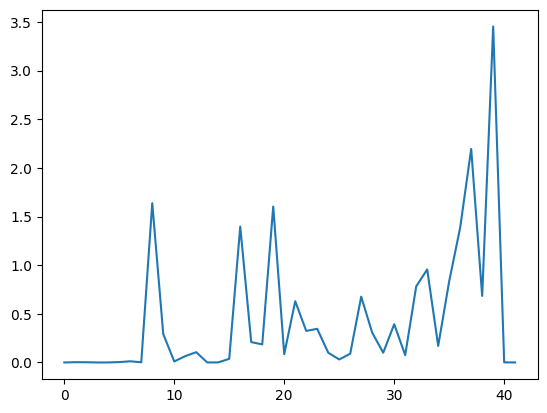

In [9]:
score=[]
for i in range(len(y)):
    score.append(mean_squared_log_error(y[i:i+1],y_pred[i:i+1])) 
import matplotlib.pyplot as plt
plt.plot(score)
print("the number of better predicted value:",np.isclose(score, 0, atol=1e-2).sum())

In [10]:
#check LB
mean_squared_log_error(y[-2:],y_pred[-2:])

0.0006452394945189557

## Submission

In [11]:
sub = pd.DataFrame({'Batch_ID': test.Batch_ID,
                       'T80': np.clip(y_test,0,None)})
sub.to_csv('submission.csv', index=False)
sub.head(10)

,Batch_ID,T80
0,Test-01,9.376646
1,Test-02,17.167608
2,Test-03,20.412531
3,Test-04,35.116611
4,Test-05,9.255750
5,Test-06,38.854258
6,Test-07,0.000000
7,Test-08,4.575606
8,Test-09,20.844693
